In [1]:
# Importar bibliotecas necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE

In [2]:
# 1. Cargar los datos
data = pd.read_csv(r"C:\Users\CINDY\Downloads\archive (1)\heart_cleveland_upload.csv")

In [3]:
# 2. Análisis exploratorio de los datos
print(data.head())  # Ver las primeras filas del dataset
print(data.describe())  # Descripción estadística

   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   69    1   0       160   234    1        2      131      0      0.1      1   
1   69    0   0       140   239    0        0      151      0      1.8      0   
2   66    0   0       150   226    0        0      114      0      2.6      2   
3   65    1   0       138   282    1        2      174      0      1.4      1   
4   64    1   0       110   211    0        2      144      1      1.8      1   

   ca  thal  condition  
0   1     0          0  
1   2     0          0  
2   0     0          0  
3   1     0          1  
4   0     0          0  
              age         sex          cp    trestbps        chol         fbs  \
count  297.000000  297.000000  297.000000  297.000000  297.000000  297.000000   
mean    54.542088    0.676768    2.158249  131.693603  247.350168    0.144781   
std      9.049736    0.468500    0.964859   17.762806   51.997583    0.352474   
min     29.000000    0.000000    0.0000

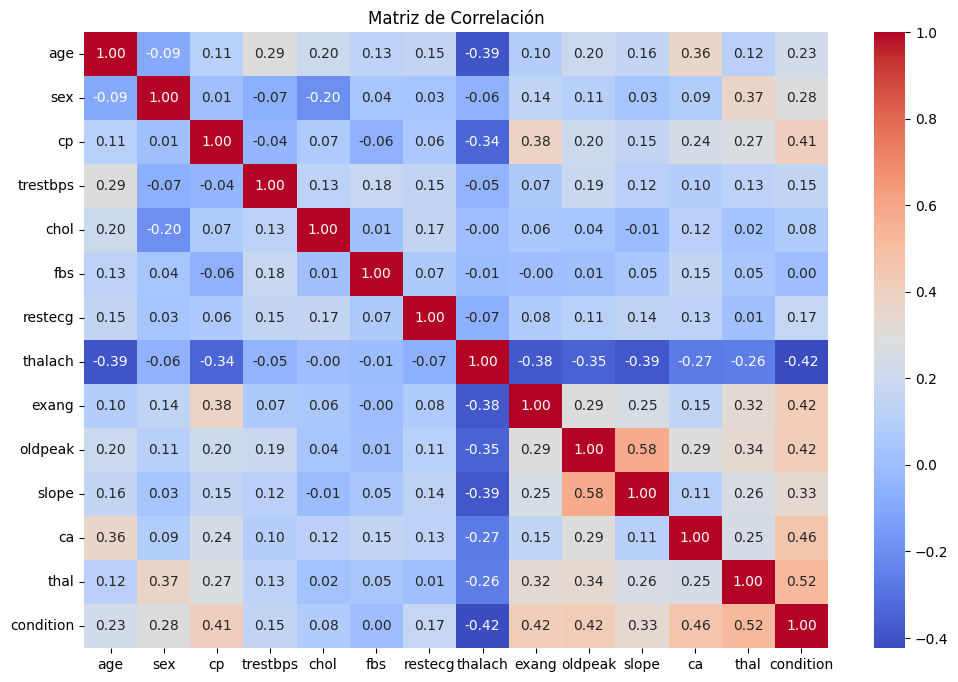

In [14]:
# Comprobar la correlación entre variables
plt.figure(figsize=(12, 8))
sns.heatmap(data.corr(), annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

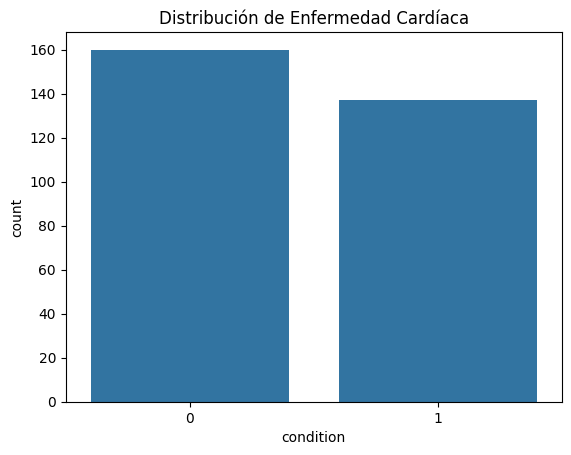

In [5]:
# Distribución de la variable objetivo
sns.countplot(x='condition', data=data)
plt.title('Distribución de Enfermedad Cardíaca')
plt.show()

In [6]:
# 3. Preprocesar los datos
# Comprobar valores nulos
print(data.isnull().sum())

age          0
sex          0
cp           0
trestbps     0
chol         0
fbs          0
restecg      0
thalach      0
exang        0
oldpeak      0
slope        0
ca           0
thal         0
condition    0
dtype: int64


In [7]:
# Rellenar valores nulos si es necesario (en este caso no parece haber nulos)
data.ffill(inplace=True)

In [8]:
# Convertir variables categóricas a variables dummy si hay alguna
data = pd.get_dummies(data, drop_first=True)

In [9]:
# Verificar la estructura del dataframe después del preprocesamiento
print(data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 297 entries, 0 to 296
Data columns (total 14 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        297 non-null    int64  
 1   sex        297 non-null    int64  
 2   cp         297 non-null    int64  
 3   trestbps   297 non-null    int64  
 4   chol       297 non-null    int64  
 5   fbs        297 non-null    int64  
 6   restecg    297 non-null    int64  
 7   thalach    297 non-null    int64  
 8   exang      297 non-null    int64  
 9   oldpeak    297 non-null    float64
 10  slope      297 non-null    int64  
 11  ca         297 non-null    int64  
 12  thal       297 non-null    int64  
 13  condition  297 non-null    int64  
dtypes: float64(1), int64(13)
memory usage: 32.6 KB
None


In [16]:
#  Seleccionar características más relevantes utilizando RFE
X = data.drop('condition', axis=1)  # Variables independientes
y = data['condition']  # Variable dependiente

model = LogisticRegression(max_iter=2000)  # Aumentar el número máximo de iteraciones
rfe = RFE(estimator=model, n_features_to_select=5)  # Seleccionar las 5 mejores características
fit = rfe.fit(X, y)

selected_features = X.columns[fit.support_]
print("Características seleccionadas:", selected_features)


Características seleccionadas: Index(['fbs', 'exang', 'slope', 'ca', 'thal'], dtype='object')


In [17]:
# Dividir el dataset en Train y Test
X_train, X_test, y_train, y_test = train_test_split(X[selected_features], y, test_size=0.2, random_state=42)

In [18]:
# Escalar las características
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)  # Ajustar y transformar el conjunto de entrenamiento
X_test_scaled = scaler.transform(X_test)        # Solo transformar el conjunto de prueba

In [19]:
# Entrenar el modelo de regresión logística
model.fit(X_train_scaled, y_train)

LogisticRegression(max_iter=2000)

In [20]:
# Evaluar el desempeño del modelo en el conjunto de Test
y_pred = model.predict(X_test_scaled)


In [21]:
# Reporte de clasificación
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.82      0.72      0.77        32
           1       0.72      0.82      0.77        28

    accuracy                           0.77        60
   macro avg       0.77      0.77      0.77        60
weighted avg       0.77      0.77      0.77        60



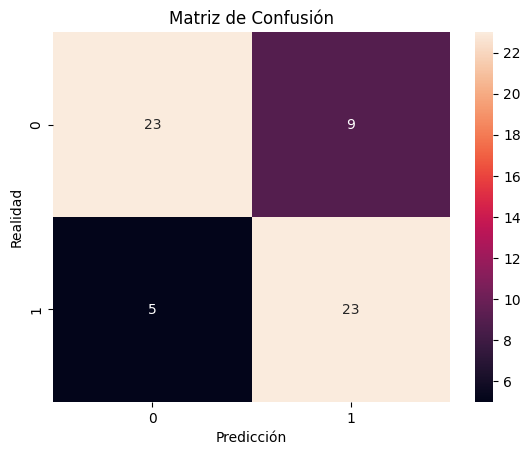

In [22]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Realidad')
plt.show()

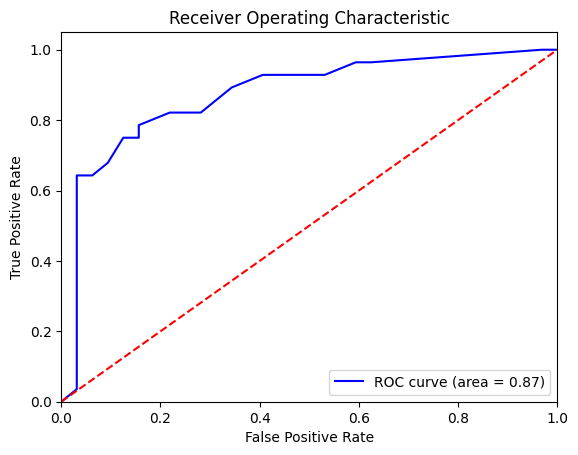

In [23]:
# Gráfico ROC-AUC para evaluar el rendimiento del modelo
from sklearn.metrics import roc_curve, roc_auc_score

y_prob = model.predict_proba(X_test_scaled)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = roc_auc_score(y_test, y_prob)

plt.figure()
plt.plot(fpr, tpr, color='blue', label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='red', linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()